In [1]:
import os
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from pathlib import Path

import torch
from torch.quasirandom import SobolEngine


from botorch import fit_gpytorch_mll
from botorch.acquisition import qLogExpectedImprovement
from botorch.models import SingleTaskGP
from botorch.models.transforms import Standardize
from botorch.optim import optimize_acqf
from botorch.sampling.stochastic_samplers import StochasticSampler
from botorch.utils.transforms import unnormalize, normalize

from gpytorch.constraints import Interval
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood


from helpers import (load_kwargs_config, 
                    compute_nrmse_counts_all_edges, 
                    parse_loop_data_xml_to_pandas, 
                    create_taz_xml,
                    simulate_od,
                    od_xml_to_df,
                    xml2df_str,
                    )


In [2]:
# base_path = "/home/bench/Gitsrcs/origin_destination_bayes_opt"
# base_path = "/Users/osorio/HEC/Research/Group/FacultyCollaborations/SeongjinChoi_UMN/Code_BO/origin_destination_bayes_opt-main"
base_path = "/Users/chois/Gitsrcs/origin_destination_bayes_opt"
os.chdir(base_path)

In [3]:
config = load_kwargs_config(base_path, "bo_vanilla")

Path(config["simulation_run_path"]).mkdir(parents=True, exist_ok=True)

In [4]:
# Get Ground Truth OD + fixed routes
print(f"Reading: {config['file_gt_od']}")
gt_od_df = od_xml_to_df(config["file_gt_od"])

print(f"Reading: {config['fixed_routes']}")
routes_df = pd.read_csv(config["fixed_routes"], index_col=0)

Reading: /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/od.xml
total GT demand:  2800.0
Reading: /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/routes.csv


## Vanilla BO


### Declare parameter space


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
dtype = torch.double

dim_od = gt_od_df.shape[0]
print(dim_od)

bounds = torch.tensor([
    [ 0 for _ in range(dim_od)],
    [ 2000 for _ in range(dim_od)]
], device=device, dtype=dtype) 

cpu
4


Run GT simulation


In [6]:
simulation_gt_run_path =f'{config["simulation_run_path"]}/ground_truth'
prefix_output_gt = f'{simulation_gt_run_path}/sim'
sim_edge_out_gt = f'{prefix_output_gt}_{config["EDGE_OUT_STR"]}'
new_od_xml = f'{simulation_gt_run_path}/od.xml'

Path(simulation_gt_run_path).mkdir(parents=True, exist_ok=True)

base_od = gt_od_df.copy()
gt_od_vals = gt_od_df['count'].astype(float).to_numpy()
curr_od = gt_od_vals.copy()
base_od['count'] = curr_od
base_od = base_od.rename(columns={'fromTaz':'from', 'toTaz':'to'})        
create_taz_xml(new_od_xml, base_od, config["od_duration_sec"], base_path)

print(base_od)

# Run simulation

simulate_od(new_od_xml, 
            prefix_output_gt, 
            base_path, 
            config["net_xml"], 
            config["taz2edge_xml"], 
            config["additional_xml"],
            routes_df,
            config["sim_end_time"],
            config["TRIPS2ODS_OUT_STR"])



Created  /Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/ground_truth/od.xml
    from     to  count  data
0  taz91  taz93  500.0  None
1  taz91  taz94  500.0  None
2  taz92  taz93  900.0  None
3  taz92  taz94  900.0  None
od2trips  --spread.uniform --taz-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/ground_truth/od.xml -o /Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/ground_truth/sim_trips_beforeRteUpdates.xml
Success.time 299.17
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/ground_truth/sim_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/ground_truth/sim_trips.xml -b 0 -e 57600 --additional-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/

Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2800 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.68s
 Real time factor: 84830.6
 UPS: 1720597.938144
Vehicles: 
 Inserted: 2800
 Running: 0
 Waiting: 0
Statistics (avg of 2800):
 RouteLength: 4459.95
 Speed: 10.71
 Duration: 417.25
 WaitingTime: 0.36
 TimeLoss: 91.33
 DepartDelay: 693.70

DijkstraRouter answered 5435 queries and explored 10.94 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).


Read output of GT simulation


In [7]:
df_edge_gt, _, _ = parse_loop_data_xml_to_pandas(base_path, sim_edge_out_gt, prefix_output_gt, config["SUMO_PATH"])
# picking at edges as GT edges
num_gt_edges = df_edge_gt.shape[0]
print("Number of GT edges:",num_gt_edges)
gt_edge_data = df_edge_gt\
    .sort_values(by=['interval_nVehContrib'], ascending=False)\
    .iloc[:num_gt_edges]

print(sim_edge_out_gt)

Number of GT edges: 14
output/quickstart_bo_vanilla/ground_truth/sim_edge_data_quickstart.xml


In [8]:
# Sample according to Sobol
sobol = SobolEngine(dim_od, scramble=True)
x_0 = sobol.draw(config["n_init_search"]).to(dtype=dtype).to(device)
# map the normalized into the original parameter space
train_X0 = unnormalize(x_0, bounds)

In [9]:
ods_epsilon = []
loss_all = []
batch_data_i = []

# Base OD which we will update their count entries
base_od = gt_od_df.copy()
gt_od_vals = gt_od_df['count'].astype(float).to_numpy()

for i , x in enumerate(train_X0.tolist()):
      print(f"########### OD: {i} ###########")
      print(x)
      
      simulation_run_path_init =f'{config["simulation_run_path"]}/initial_search'
      Path(simulation_run_path_init).mkdir(parents=True, exist_ok=True)
      
      new_od_xml = f"{simulation_run_path_init}/gt_od_{config['network_name']}_{i}.xml"
      prefix_output_init = f'{simulation_run_path_init}/sobol_{i}'

      # Generate OD
      #curr_od = gt_od_vals.copy()
      curr_od = np.array(x)

      print(f'total expected GT demand: {np.sum(curr_od)}')

      ###
      # create OD xml file 
      ###
      base_od['count'] = curr_od
      # round to 1 decimal point
      base_od['count'] = [round(elem, 1) for elem in base_od['count']]     
      base_od = base_od.rename(columns={'fromTaz':'from', 'toTaz':'to'})        
      create_taz_xml(new_od_xml, base_od, config["od_duration_sec"], base_path)
      ods_epsilon.append(curr_od)

      # simulate initial search
      simulate_od(new_od_xml, 
                  prefix_output_init, 
                  base_path, 
                  config["net_xml"], 
                  config["taz2edge_xml"], 
                  config["additional_xml"],
                  routes_df,
                  config["sim_end_time"],
                  config["TRIPS2ODS_OUT_STR"])

      ## Compute loss
      #prefix_output = f'initial_search/sobol_{i}'
      sim_edge_out = f'{base_path}/{prefix_output_init}_{config["EDGE_OUT_STR"]}'
      print(sim_edge_out)
      curr_loop_stats, _, _ = parse_loop_data_xml_to_pandas(base_path, sim_edge_out,prefix_output_init,config["SUMO_PATH"])
      curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, curr_loop_stats)

      loss_all.append(curr_loss)
      print(f"############## loss: {curr_loss} ##############")

      # Parse training data
      df_curr = pd.DataFrame(curr_od.reshape(1,dim_od),
                        columns = [f"x_{i+1}" for i in range(dim_od)])
      df_curr['loss'] = curr_loss
      batch_data_i.append(df_curr)

df_initial_bo = pd.concat(batch_data_i)
# Save initial dataset
df_initial_bo.to_csv(f"{config['simulation_run_path']}/initial_search/data_set_ods_0_2000.csv",index=None)
print(f"save df_initial_bo at {config['simulation_run_path']}/initial_search/data_set_ods_0_2000.csv")


########### OD: 0 ###########
[33.6868017911911, 952.3778557777405, 1910.1415872573853, 598.0713963508606]
total expected GT demand: 3494.2776411771774
Created  /Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/gt_od_quickstart_0.xml
od2trips  --spread.uniform --taz-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/initial_search/gt_od_quickstart_0.xml -o /Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_0_trips_beforeRteUpdates.xml
Success.time 299.75
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/initial_search/sobol_0_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_0_trips.xml -b 0 -e 57600 --additi

Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (1ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 3495 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 1.06s
 Real time factor: 54288.4
 UPS: 1306836.946277
Vehicles: 
 Inserted: 3495
 Running: 0
 Waiting: 0
Statistics (avg of 3495):
 RouteLength: 4148.02
 Speed: 10.49
 Duration: 396.73
 WaitingTime: 0.24
 TimeLoss: 93.59
 DepartDelay: 1010.07

DijkstraRouter answered 6825 queries and explored 9.71 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_0_edge_data_quickstart.xml
############## loss: 0.34223545354560686 ##############
########### OD: 1 ###########
[125

Success.time 299.90
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/initial_search/sobol_1_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_1_trips.xml -b 0 -e 57600 --additional-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0


Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (2ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 4776 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 1.64s
 Real time factor: 35186.3
 UPS: 1260367.745877
Vehicles: 
 Inserted: 4776
 Running: 0
 Waiting: 0
Statistics (avg of 4776):
 RouteLength: 4534.43
 Speed: 10.52
 Duration: 432.00
 WaitingTime: 0.36
 TimeLoss: 101.03
 DepartDelay: 1237.40

DijkstraRouter answered 9408 queries and explored 11.27 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobo

Success.time 299.48
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/initial_search/sobol_2_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_2_trips.xml -b 0 -e 57600 --additional-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (1ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 3361 ACT 0 BUF 0)            

Success.time 299.29
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/initial_search/sobol_3_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_3_trips.xml -b 0 -e 57600 --additional-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (3ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 4936 ACT 0 BUF 0)            

###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/initial_search/sobol_4_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_4_trips.xml -b 0 -e 57600 --additional-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (1ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 3311 ACT 0 BUF 0)                            
Sim

###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/initial_search/sobol_5_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_5_trips.xml -b 0 -e 57600 --additional-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (2ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 4751 ACT 0 BUF 0)                            
Sim

###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/initial_search/sobol_6_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_6_trips.xml -b 0 -e 57600 --additional-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (2ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 3740 ACT 0 BUF 0)                            
Sim

Success.time 299.09
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/initial_search/sobol_7_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_7_trips.xml -b 0 -e 57600 --additional-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (2ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 4504 ACT 0 BUF 0)            

###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/initial_search/sobol_8_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_8_trips.xml -b 0 -e 57600 --additional-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (3ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 1142 ACT 0 BUF 0)                            
Sim

Success.time 299.58
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/initial_search/sobol_9_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_9_trips.xml -b 0 -e 57600 --additional-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (2ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.


Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 5153 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 1.76s
 Real time factor: 32783.2
 UPS: 1250069.436540
Vehicles: 
 Inserted: 5153
 Running: 0
 Waiting: 0
Statistics (avg of 5153):
 RouteLength: 4498.92
 Speed: 10.58
 Duration: 426.23
 WaitingTime: 0.34
 TimeLoss: 97.70
 DepartDelay: 1298.21

DijkstraRouter answered 10166 queries and explored 11.11 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_9_edge_data_quickstart.xml
############## loss: 0.9123367858526529 ##############
########### OD: 10 ###########
[1821.1557865142822, 813.6299252510071, 99.17686879634857, 940.960168838501]
total expected GT demand: 3674.922749400139
Created  /Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_b

Success.time 299.26
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/initial_search/sobol_10_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_10_trips.xml -b 0 -e 57600 --additional-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0


Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (1ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 3675 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 1.12s
 Real time factor: 51336.9
 UPS: 1456829.768271
Vehicles: 
 Inserted: 3675
 Running: 0
 Waiting: 0
Statistics (avg of 3675):
 RouteLength: 4705.80
 Speed: 10.63
 Duration: 444.78
 WaitingTime: 0.32
 TimeLoss: 101.11
 DepartDelay: 1071.36

DijkstraRouter answered 7191 queries and explored 11.93 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobo

Success.time 299.22
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/initial_search/sobol_11_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_11_trips.xml -b 0 -e 57600 --additional-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (1ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.


Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 5023 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 1.67s
 Real time factor: 34470.4
 UPS: 1220210.652304
Vehicles: 
 Inserted: 5023
 Running: 0
 Waiting: 0
Statistics (avg of 5023):
 RouteLength: 4301.09
 Speed: 10.61
 Duration: 405.93
 WaitingTime: 0.31
 TimeLoss: 91.92
 DepartDelay: 1263.29

DijkstraRouter answered 9904 queries and explored 10.32 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_11_edge_data_quickstart.xml
############## loss: 0.8140576752067236 ##############
########### OD: 12 ###########
[928.6977648735046, 744.1678643226624, 1308.363914489746, 1250.4568099975586]
total expected GT demand: 4231.686353683472
Created  /Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_

Success.time 299.16
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/initial_search/sobol_12_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_12_trips.xml -b 0 -e 57600 --additional-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).


Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (8ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 4231 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 1.34s
 Real time factor: 43113.8
 UPS: 1329656.437126
Vehicles: 
 Inserted: 4231
 Running: 0
 Waiting: 0
Statistics (avg of 4231):
 RouteLength: 4474.62
 Speed: 10.67
 Duration: 419.86
 WaitingTime: 0.38
 TimeLoss: 93.02
 DepartDelay: 1081.13

DijkstraRouter answered 8314 queries and explored 11.02 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_12_edge_data_quickstart.xml
############## loss: 0.526079898087351 ##############
########### OD: 13 ###########
[16

Success.time 299.73
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/initial_search/sobol_13_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_13_trips.xml -b 0 -e 57600 --additional-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).


Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (10ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 4928 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 1.82s
 Real time factor: 31683.2
 UPS: 1120253.575358
Vehicles: 
 Inserted: 4928
 Running: 0
 Waiting: 0
Statistics (avg of 4928):
 RouteLength: 4425.84
 Speed: 10.73
 Duration: 413.27
 WaitingTime: 0.34
 TimeLoss: 90.17
 DepartDelay: 1464.16

DijkstraRouter answered 9710 queries and explored 10.83 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_13_edge_data_quickstart.xml
############## loss: 1.0683550449701968 ##############
########### OD: 14 ###########
[

Success.time 299.90
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/initial_search/sobol_14_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_14_trips.xml -b 0 -e 57600 --additional-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).


Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (8ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 5232 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 1.94s
 Real time factor: 29767.4
 UPS: 1171919.896641
Vehicles: 
 Inserted: 5232
 Running: 0
 Waiting: 0
Statistics (avg of 5232):
 RouteLength: 4537.28
 Speed: 10.52
 Duration: 433.42
 WaitingTime: 0.35
 TimeLoss: 102.11
 DepartDelay: 1446.35

DijkstraRouter answered 10323 queries and explored 11.28 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_14_edge_data_quickstart.xml
############## loss: 0.9818962281595998 ##############
########### OD: 15 ###########


Success.time 299.38
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/initial_search/sobol_15_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_15_trips.xml -b 0 -e 57600 --additional-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (9ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2240 ACT 0 BUF 0)          

Success.time 299.12
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/initial_search/sobol_16_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_16_trips.xml -b 0 -e 57600 --additional-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (10ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2710 ACT 0 BUF 0)         

Success.time 299.05
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/initial_search/sobol_17_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_17_trips.xml -b 0 -e 57600 --additional-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).


Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (15ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 4039 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 1.63s
 Real time factor: 35446.2
 UPS: 1047864.615385
Vehicles: 
 Inserted: 4039
 Running: 0
 Waiting: 0
Statistics (avg of 4039):
 RouteLength: 4518.87
 Speed: 10.75
 Duration: 421.58
 WaitingTime: 0.36
 TimeLoss: 91.42
 DepartDelay: 1061.61

DijkstraRouter answered 7927 queries and explored 11.19 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_17_edge_data_quickstart.xml
############## loss: 0.6837303515097565 ##############
########### OD: 18 ###########
[

Success.time 299.57
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/initial_search/sobol_18_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_18_trips.xml -b 0 -e 57600 --additional-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... 

done (4ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (11ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 5792 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 2.81s
 Real time factor: 20476.4
 UPS: 891250.977604
Vehicles: 
 Inserted: 5792
 Running: 0
 Waiting: 0
Statistics (avg of 5792):
 RouteLength: 4582.96
 Speed: 10.61
 Duration: 432.85
 WaitingTime: 0.36
 TimeLoss: 98.26
 DepartDelay: 1516.47

DijkstraRouter answered 11444 queries and explored 11.46 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_18_edge_data_quickstart.xml
############## loss: 1.1311270832424765 ##############
########### OD: 19 #

Success.time 299.08
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/initial_search/sobol_19_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_19_trips.xml -b 0 -e 57600 --additional-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (14ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2794 ACT 0 BUF 0)         

Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (9ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2457 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.54s
 Real time factor: 106470
 UPS: 1841229.205176
Vehicles: 
 Inserted: 2457
 Running: 0
 Waiting: 0
Statistics (avg of 2457):
 RouteLength: 4305.02
 Speed: 10.64
 Duration: 405.42
 WaitingTime: 0.28
 TimeLoss: 90.92
 DepartDelay: 535.36

DijkstraRouter answered 4745 queries and explored 10.33 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_20_edge_data_quickstart.xml
############## loss: 0.30278274058575194 ##############
########### OD: 21 ###########
[17

Success.time 299.91
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/initial_search/sobol_21_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_21_trips.xml -b 0 -e 57600 --additional-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (10ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.


Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 6470 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 2.92s
 Real time factor: 19712.5
 UPS: 938970.568104
Vehicles: 
 Inserted: 6470
 Running: 0
 Waiting: 0
Statistics (avg of 6470):
 RouteLength: 4499.68
 Speed: 10.63
 Duration: 424.06
 WaitingTime: 0.38
 TimeLoss: 95.67
 DepartDelay: 1668.40

DijkstraRouter answered 12800 queries and explored 11.14 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_21_edge_data_quickstart.xml
############## loss: 1.3790353066573777 ##############
########### OD: 22 ###########
[1102.6921272277832, 180.6030571460724, 283.47232937812805, 502.8112530708313]
total expected GT demand: 2069.578766822815
Created  /Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart

Success.time 299.47
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/initial_search/sobol_22_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_22_trips.xml -b 0 -e 57600 --additional-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (10ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2068 ACT 0 BUF 0)         

Success.time 299.75
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/initial_search/sobol_23_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_23_trips.xml -b 0 -e 57600 --additional-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).


Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (30ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 4791 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 1.75s
 Real time factor: 32914.3
 UPS: 1106590.857143
Vehicles: 
 Inserted: 4791
 Running: 0
 Waiting: 0
Statistics (avg of 4791):
 RouteLength: 4323.38
 Speed: 10.71
 Duration: 404.20
 WaitingTime: 0.29
 TimeLoss: 88.59
 DepartDelay: 1339.34

DijkstraRouter answered 9437 queries and explored 10.41 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_23_edge_data_quickstart.xml
############## loss: 0.7577291785528858 ##############
########### OD: 24 ###########
[

Success.time 298.93
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/initial_search/sobol_24_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_24_trips.xml -b 0 -e 57600 --additional-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (10ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2903 ACT 0 BUF 0)         

Success.time 299.11
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/initial_search/sobol_25_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_25_trips.xml -b 0 -e 57600 --additional-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).


Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (8ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 5473 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 2.03s
 Real time factor: 28388.4
 UPS: 1087341.054707
Vehicles: 
 Inserted: 5473
 Running: 0
 Waiting: 0
Statistics (avg of 5473):
 RouteLength: 4258.62
 Speed: 10.59
 Duration: 403.11
 WaitingTime: 0.29
 TimeLoss: 92.17
 DepartDelay: 1404.00

DijkstraRouter answered 10807 queries and explored 10.15 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_25_edge_data_quickstart.xml
############## loss: 1.0589963788963768 ##############
########### OD: 26 ###########
[

Success.time 299.00
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/initial_search/sobol_26_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_26_trips.xml -b 0 -e 57600 --additional-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).


Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (13ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 4668 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 1.60s
 Real time factor: 35932.6
 UPS: 1290520.274485
Vehicles: 
 Inserted: 4668
 Running: 0
 Waiting: 0
Statistics (avg of 4668):
 RouteLength: 4672.03
 Speed: 10.57
 Duration: 443.17
 WaitingTime: 0.39
 TimeLoss: 102.10
 DepartDelay: 1150.92

DijkstraRouter answered 9191 queries and explored 11.83 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_26_edge_data_quickstart.xml
############## loss: 0.8290416255569866 ##############
########### OD: 27 ###########


Success.time 298.95
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/initial_search/sobol_27_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_27_trips.xml -b 0 -e 57600 --additional-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (9ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.


Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 3928 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 1.15s
 Real time factor: 50305.7
 UPS: 1390477.729258
Vehicles: 
 Inserted: 3928
 Running: 0
 Waiting: 0
Statistics (avg of 3928):
 RouteLength: 4334.55
 Speed: 10.71
 Duration: 405.32
 WaitingTime: 0.28
 TimeLoss: 88.61
 DepartDelay: 956.52

DijkstraRouter answered 7708 queries and explored 10.45 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_27_edge_data_quickstart.xml
############## loss: 0.4255243893329262 ##############
########### OD: 28 ###########
[753.4633278846741, 53.60438674688339, 1722.8552103042603, 911.1602306365967]
total expected GT demand: 3441.0831555724144
Created  /Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_

Success.time 299.91
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/initial_search/sobol_28_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_28_trips.xml -b 0 -e 57600 --additional-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (11ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.


Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 3441 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 1.06s
 Real time factor: 54288.4
 UPS: 1449180.961357
Vehicles: 
 Inserted: 3441
 Running: 0
 Waiting: 0
Statistics (avg of 3441):
 RouteLength: 4443.90
 Speed: 10.23
 Duration: 446.84
 WaitingTime: 0.32
 TimeLoss: 122.03
 DepartDelay: 1079.96

DijkstraRouter answered 6710 queries and explored 10.85 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_28_edge_data_quickstart.xml
############## loss: 0.516160970128201 ##############
########### OD: 29 ###########
[1538.209080696106, 1397.2898721694946, 233.34923386573792, 1060.5427026748657]
total expected GT demand: 4229.390889406204
Created  /Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstar

Success.time 299.58
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/initial_search/sobol_29_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_29_trips.xml -b 0 -e 57600 --additional-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).


Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (29ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 4230 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 1.43s
 Real time factor: 40223.5
 UPS: 1267780.726257
Vehicles: 
 Inserted: 4230
 Running: 0
 Waiting: 0
Statistics (avg of 4230):
 RouteLength: 4571.77
 Speed: 10.69
 Duration: 429.19
 WaitingTime: 0.39
 TimeLoss: 95.25
 DepartDelay: 1208.84

DijkstraRouter answered 8310 queries and explored 11.40 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/initial_search/sobol_29_edge_data_quickstart.xml
############## loss: 0.8445128693365562 ##############
save df_initial_bo at output/qui

#### Bayesian optimization helpers


In [10]:

def initialize_gp_model(train_X,train_Y):
    
    dim = train_X.size(dim=1)

    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
    covar_module = ScaleKernel(  # Use the same lengthscale prior as in the TuRBO paper
        MaternKernel(
            nu=2.5, ard_num_dims=dim, lengthscale_constraint=Interval(0.005, 4.0)
        )
    )

    gp_model = SingleTaskGP(
        train_X, train_Y, 
        covar_module=covar_module, likelihood=likelihood, 
        outcome_transform=Standardize(m=1)
    )

    gp_mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
    
    return gp_model, gp_mll


In [11]:

def optimize_acqf_and_get_observation(acq_func, bounds, device, dtype, BATCH_SIZE, NUM_RESTARTS, RAW_SAMPLES):
    """Optimizes the acquisition function, and returns a new candidate."""

    dim = acq_func.model.train_inputs[0].size(dim=1)

    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=torch.tensor([[0.0] * dim, [1.0] * dim], device=device, dtype=dtype),
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
    )

    # observe new values 
    new_x = candidates.detach()
    
    return unnormalize(new_x, bounds)


In [13]:
sampler = StochasticSampler(sample_shape=torch.Size([config["SAMPLE_SHAPE"]])) # TODO : sample shape from sim_setup?
df_0 = pd.read_csv(f"{config['simulation_run_path']}/initial_search/data_set_ods_0_2000.csv")

### Run loop
best_value = []

# Data frame of current training data
df_training = df_0
df_training["bo_iteration"] = 0

df_edge_stats = pd.DataFrame()

#num_epsilon_iter = 2
ods_epsilon = []
loss_all = []
batch_data_i = []

# Base OD which we will update their count entries
base_od = gt_od_df.copy()
gt_od_vals = gt_od_df['count'].astype(float).to_numpy()

for i in range(config["NITER"]):
    new_od_xml = f'{config["simulation_run_path"]}/od.xml'

    simulation_run_path_BO =f'{config["simulation_run_path"]}/BO'
    prefix_output_bo = f'{simulation_run_path_BO}/bayesOpt_{i}'
    Path(simulation_run_path_BO).mkdir(parents=True, exist_ok=True)

    ########
    # Start BO step
    ########

    print(f"########### BO iteration={i+1} ###########")

    # Obtain sampling locations x
    train_X = torch.from_numpy(
        df_training[[col for col in df_training.columns if "x" in col]].values
    ).to(device=device, dtype=dtype)

    # Normalize
    train_X_norm = normalize(train_X,bounds)

    # Obtain reponse data
    train_Y = -torch.from_numpy(df_training[["loss"]].values) # Take negative

    # best value so far
    best_y = train_Y.max()
    best_value.append(best_y)
    print(f"##### best_value={best_y} #####")

    print(f"Generating new sampling location(s)....")
    # Declare model with newest data
    gp_model, gp_mll = initialize_gp_model(train_X_norm,train_Y)

    # Fit model
    fit_gpytorch_mll(gp_mll)

    # Construct acquistion function 
    # sampler = StochasticSampler(sample_shape=torch.Size([128]))
    qEI = qLogExpectedImprovement(gp_model, best_f=best_y, sampler=sampler)

    # Maximize acquisition function to get next observation
    x_i = optimize_acqf_and_get_observation(acq_func=qEI,
                                            bounds=bounds,
                                            device=device,
                                            dtype=dtype,
                                            BATCH_SIZE=config["BATCH_SIZE"],
                                            NUM_RESTARTS=config["BATCH_SIZE"],
                                            RAW_SAMPLES=config["BATCH_SIZE"])

    # map the normalized into the original parameter space
    #x_i = unnormalize(x_i, bounds)
    x_i = x_i.cpu().detach().numpy()

    ########
    # End BO step
    ########    


    # Sample simulator (inner loop across all sampling locations within a batch)
    # TODO: Parallelize
    batch_data_i = []
    for j in range(config["BATCH_SIZE"]):
        loss_all = []
        print(f"########### Sampling location={j+1} ###########")

        # Generate OD
        #curr_od = gt_od_vals.copy()
        curr_od = x_i[j]

        print(f'total expected GT demand: {np.sum(curr_od)}')

        base_od['count'] = curr_od
        # round to 1 decimal point
        base_od['count'] = [round(elem, 1) for elem in base_od['count']]     
        base_od = base_od.rename(columns={'fromTaz':'from', 'toTaz':'to'})        
        create_taz_xml(new_od_xml, base_od, config["od_duration_sec"], base_path)

        # simulate gt od
        simulate_od(new_od_xml, 
                    prefix_output_bo, 
                    base_path, 
                    config["net_xml"], 
                    config["taz2edge_xml"], 
                    config["additional_xml"],
                    routes_df,
                    config["sim_end_time"],
                    config["TRIPS2ODS_OUT_STR"])

        ## Compute loss
        sim_edge_out = f'{base_path}/{prefix_output_bo}_{config["EDGE_OUT_STR"]}'
        print(sim_edge_out)
        curr_loop_stats, _, _ = parse_loop_data_xml_to_pandas(base_path, sim_edge_out,prefix_output_bo,config["SUMO_PATH"])
        
        curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, curr_loop_stats)
        loss_all.append(curr_loss)
        print(f"############## loss: {curr_loss} ##############")

        # Parse training data
        df_j = pd.DataFrame(x_i[j].reshape(1,dim_od),
                            columns = [f"x_{i+1}" for i in range(dim_od)])
        df_j['loss'] = curr_loss
        batch_data_i.append(df_j)

        curr_loop_stats['bo_iteration'] = i
        curr_loop_stats['batch'] = j
        df_edge_stats = pd.concat([df_edge_stats, curr_loop_stats])

    df_i = pd.concat(batch_data_i)
    df_i["bo_iteration"] = i+1

    df_training = pd.concat([df_training,df_i])


########### BO iteration=1 ###########
##### best_value=-0.2996461000774604 #####
Generating new sampling location(s)....
########### Sampling location=1 ###########
total expected GT demand: 2791.474708681952
Created  /Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/od.xml
od2trips  --spread.uniform --taz-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/od.xml -o /Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_0_trips_beforeRteUpdates.xml
Success.time 299.05
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/bayesOpt_0_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_0_trips.xml -b 0 -e 57600 --additional-files /Users/chois/Gitsrcs

Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (10ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2790 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.70s
 Real time factor: 82168.3
 UPS: 1672694.721826
Vehicles: 
 Inserted: 2790
 Running: 0
 Waiting: 0
Statistics (avg of 2790):
 RouteLength: 4517.05
 Speed: 10.78
 Duration: 420.27
 WaitingTime: 0.36
 TimeLoss: 90.25
 DepartDelay: 682.37

DijkstraRouter answered 5412 queries and explored 11.17 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_0_edge_d

###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/bayesOpt_1_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_1_trips.xml -b 0 -e 57600 --additional-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (11ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2559 ACT 0 BUF 0)                            
Simulation ended at 

Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (9ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 3077 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.80s
 Real time factor: 72180.5
 UPS: 1652155.388471
Vehicles: 
 Inserted: 3077
 Running: 0
 Waiting: 0
Statistics (avg of 3077):
 RouteLength: 4601.13
 Speed: 10.77
 Duration: 428.48
 WaitingTime: 0.34
 TimeLoss: 92.19
 DepartDelay: 742.83

DijkstraRouter answered 5999 queries and explored 11.55 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_2_edge_da

Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (7ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2439 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.61s
 Real time factor: 94271.7
 UPS: 1727623.567921
Vehicles: 
 Inserted: 2439
 Running: 0
 Waiting: 0
Statistics (avg of 2439):
 RouteLength: 4618.02
 Speed: 10.71
 Duration: 432.79
 WaitingTime: 0.33
 TimeLoss: 95.42
 DepartDelay: 658.49

DijkstraRouter answered 4669 queries and explored 11.61 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_3_edge_data_quickstart.xml
############## loss: 0.15910038724222367 ##############
########### BO iteration=5 ###########
####

###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/bayesOpt_4_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_4_trips.xml -b 0 -e 57600 --additional-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (8ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2888 ACT 0 BUF 0)                            
Simulation ended at t

Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (10ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2911 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.76s
 Real time factor: 76291.4
 UPS: 1647421.192053
Vehicles: 
 Inserted: 2911
 Running: 0
 Waiting: 0
Statistics (avg of 2911):
 RouteLength: 4541.36
 Speed: 10.66
 Duration: 427.28
 WaitingTime: 0.34
 TimeLoss: 95.40
 DepartDelay: 727.84

DijkstraRouter answered 5664 queries and explored 11.27 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_5_edge_d

Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (8ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 3147 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.81s
 Real time factor: 71464
 UPS: 1595119.106700
Vehicles: 
 Inserted: 3147
 Running: 0
 Waiting: 0
Statistics (avg of 3147):
 RouteLength: 4393.65
 Speed: 10.78
 Duration: 408.54
 WaitingTime: 0.33
 TimeLoss: 87.10
 DepartDelay: 747.48

DijkstraRouter answered 6136 queries and explored 10.69 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_6_edge_data

Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (7ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2632 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.62s
 Real time factor: 93053.3
 UPS: 1869260.096931
Vehicles: 
 Inserted: 2632
 Running: 0
 Waiting: 0
Statistics (avg of 2632):
 RouteLength: 4651.55
 Speed: 10.61
 Duration: 439.62
 WaitingTime: 0.31
 TimeLoss: 99.84
 DepartDelay: 596.58

DijkstraRouter answered 5098 queries and explored 11.71 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_7_edge_data_quickstart.xml
############## loss: 0.15480634427097195 ##############
########### BO iteration=9 ###########
####

###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/bayesOpt_8_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_8_trips.xml -b 0 -e 57600 --additional-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (8ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.


Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2811 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.72s
 Real time factor: 80000
 UPS: 1653286.111111
Vehicles: 
 Inserted: 2811
 Running: 0
 Waiting: 0
Statistics (avg of 2811):
 RouteLength: 4505.67
 Speed: 10.67
 Duration: 423.47
 WaitingTime: 0.35
 TimeLoss: 94.20
 DepartDelay: 698.36

DijkstraRouter answered 5456 queries and explored 11.11 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_8_edge_data_quickstart.xml
############## loss: 0.025712994238254988 ##############
########### BO iteration=10 ###########
##### best_value=-0.025712994238254988 #####
Generating new sampling location(s)....
########### Sampling location=1 ###########
total expected GT demand: 2691.1858197546703
Created  /Users/chois/Gitsr

Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (8ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2691 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.66s
 Real time factor: 87405.2
 UPS: 1680798.179059
Vehicles: 
 Inserted: 2691
 Running: 0
 Waiting: 0
Statistics (avg of 2691):
 RouteLength: 4379.14
 Speed: 10.66
 Duration: 411.61
 WaitingTime: 0.29
 TimeLoss: 91.80
 DepartDelay: 673.29

DijkstraRouter answered 5215 queries and explored 10.63 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_9_edge_data_quickstart.xml
############## loss: 0.12595249946596707 ##############
########### BO iteration=11 ###########
###

Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (8ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2861 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.74s
 Real time factor: 78048.8
 UPS: 1616310.298103
Vehicles: 
 Inserted: 2861
 Running: 0
 Waiting: 0
Statistics (avg of 2861):
 RouteLength: 4484.03
 Speed: 10.78
 Duration: 416.93
 WaitingTime: 0.35
 TimeLoss: 89.26
 DepartDelay: 723.76

DijkstraRouter answered 5563 queries and explored 11.03 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_10_edge_data_quickstart.xml
############## loss: 0.0453888059156814 ##############
########### BO iteration=12 ###########
###

Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (9ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2855 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.76s
 Real time factor: 76089.8
 UPS: 1588887.714663
Vehicles: 
 Inserted: 2855
 Running: 0
 Waiting: 0
Statistics (avg of 2855):
 RouteLength: 4497.78
 Speed: 10.71
 Duration: 421.29
 WaitingTime: 0.35
 TimeLoss: 92.55
 DepartDelay: 725.28

DijkstraRouter answered 5543 queries and explored 11.11 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_11_edge_d

Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (8ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2615 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.63s
 Real time factor: 91719.7
 UPS: 1768243.630573
Vehicles: 
 Inserted: 2615
 Running: 0
 Waiting: 0
Statistics (avg of 2615):
 RouteLength: 4505.36
 Speed: 10.63
 Duration: 424.65
 WaitingTime: 0.37
 TimeLoss: 95.35
 DepartDelay: 632.09

DijkstraRouter answered 5061 queries and explored 11.12 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_12_edge_data_quickstart.xml
############## loss: 0.06984314027482483 ##############
########### BO iteration=14 ###########
##

Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (7ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2874 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.73s
 Real time factor: 78688.5
 UPS: 1648959.016393
Vehicles: 
 Inserted: 2874
 Running: 0
 Waiting: 0
Statistics (avg of 2874):
 RouteLength: 4497.36
 Speed: 10.73
 Duration: 419.99
 WaitingTime: 0.35
 TimeLoss: 91.35
 DepartDelay: 725.36

DijkstraRouter answered 5584 queries and explored 11.09 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_13_edge_data_quickstart.xml
############## loss: 0.04962198610141675 ##############
########### BO iteration=15 ###########
##

Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (9ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2831 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.73s
 Real time factor: 78474.1
 UPS: 1633880.108992
Vehicles: 
 Inserted: 2831
 Running: 0
 Waiting: 0
Statistics (avg of 2831):
 RouteLength: 4496.02
 Speed: 10.64
 Duration: 423.62
 WaitingTime: 0.37
 TimeLoss: 94.96
 DepartDelay: 719.14

DijkstraRouter answered 5499 queries and explored 11.10 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_14_edge_data_quickstart.xml
############## loss: 0.037977169811359186 ##############
########### BO iteration=16 ###########
#

Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (9ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2852 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.76s
 Real time factor: 75989.4
 UPS: 1580063.324538
Vehicles: 
 Inserted: 2852
 Running: 0
 Waiting: 0
Statistics (avg of 2852):
 RouteLength: 4494.22
 Speed: 10.72
 Duration: 419.95
 WaitingTime: 0.36
 TimeLoss: 91.60
 DepartDelay: 719.70

DijkstraRouter answered 5540 queries and explored 11.08 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_15_edge_data_quickstart.xml
############## loss: 0.038145958064421163 ##############
########### BO iteration=17 ###########
#

Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (7ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2857 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.73s
 Real time factor: 78904.1
 UPS: 1647557.534247
Vehicles: 
 Inserted: 2857
 Running: 0
 Waiting: 0
Statistics (avg of 2857):
 RouteLength: 4489.54
 Speed: 10.69
 Duration: 420.97
 WaitingTime: 0.36
 TimeLoss: 92.86
 DepartDelay: 723.41

DijkstraRouter answered 5556 queries and explored 11.06 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_16_edge_data_quickstart.xml
############## loss: 0.040050158745673865 ##############
########### BO iteration=18 ###########
#

Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (11ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2849 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.78s
 Real time factor: 74322.6
 UPS: 1539011.612903
Vehicles: 
 Inserted: 2849
 Running: 0
 Waiting: 0
Statistics (avg of 2849):
 RouteLength: 4495.11
 Speed: 10.76
 Duration: 418.65
 WaitingTime: 0.35
 TimeLoss: 90.24
 DepartDelay: 722.16

DijkstraRouter answered 5539 queries and explored 11.08 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_17_edge_data_quickstart.xml
############## loss: 0.03939472311917571 ##############
########### BO iteration=19 ###########
#

Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (8ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2861 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.73s
 Real time factor: 79448.3
 UPS: 1659172.413793
Vehicles: 
 Inserted: 2861
 Running: 0
 Waiting: 0
Statistics (avg of 2861):
 RouteLength: 4494.96
 Speed: 10.72
 Duration: 420.45
 WaitingTime: 0.36
 TimeLoss: 92.02
 DepartDelay: 727.41

DijkstraRouter answered 5560 queries and explored 11.08 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_18_edge_data_quickstart.xml
############## loss: 0.044123376552693924 ##############
########### BO iteration=20 ###########
#

Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (7ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2860 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.72s
 Real time factor: 80222.8
 UPS: 1677129.526462
Vehicles: 
 Inserted: 2860
 Running: 0
 Waiting: 0
Statistics (avg of 2860):
 RouteLength: 4493.78
 Speed: 10.70
 Duration: 421.04
 WaitingTime: 0.36
 TimeLoss: 92.69
 DepartDelay: 727.00

DijkstraRouter answered 5556 queries and explored 11.09 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_19_edge_data_quickstart.xml
############## loss: 0.04667245264618245 ##############
########### BO iteration=21 ###########
##

Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (9ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2830 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.72s
 Real time factor: 80559.4
 UPS: 1661356.643357
Vehicles: 
 Inserted: 2830
 Running: 0
 Waiting: 0
Statistics (avg of 2830):
 RouteLength: 4495.52
 Speed: 10.74
 Duration: 419.74
 WaitingTime: 0.36
 TimeLoss: 91.25
 DepartDelay: 714.80

DijkstraRouter answered 5495 queries and explored 11.08 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_20_edge_data_quickstart.xml
############## loss: 0.03377239715811685 ##############
########### BO iteration=22 ###########
##

###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/bayesOpt_21_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_21_trips.xml -b 0 -e 57600 --additional-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (8ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2838 ACT 0 BUF 0)                            
Simulation ended at

Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (7ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2876 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.71s
 Real time factor: 80672.3
 UPS: 1695309.523810
Vehicles: 
 Inserted: 2876
 Running: 0
 Waiting: 0
Statistics (avg of 2876):
 RouteLength: 4492.57
 Speed: 10.70
 Duration: 420.88
 WaitingTime: 0.36
 TimeLoss: 92.58
 DepartDelay: 726.46

DijkstraRouter answered 5591 queries and explored 11.07 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_22_edge_data_quickstart.xml
############## loss: 0.04856521266973722 ##############
########### BO iteration=24 ###########
##

Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (7ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2831 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.73s
 Real time factor: 79448.3
 UPS: 1637922.758621
Vehicles: 
 Inserted: 2831
 Running: 0
 Waiting: 0
Statistics (avg of 2831):
 RouteLength: 4499.82
 Speed: 10.75
 Duration: 419.46
 WaitingTime: 0.36
 TimeLoss: 90.64
 DepartDelay: 716.50

DijkstraRouter answered 5494 queries and explored 11.11 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_23_edge_data_quickstart.xml
############## loss: 0.03427981422888989 ##############
########### BO iteration=25 ###########
##

Success.time 299.60
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/bayesOpt_24_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_24_trips.xml -b 0 -e 57600 --additional-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).


Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (13ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2298 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.51s
 Real time factor: 114059
 UPS: 2391532.673267
Vehicles: 
 Inserted: 2298
 Running: 0
 Waiting: 0
Statistics (avg of 2298):
 RouteLength: 4615.60
 Speed: 9.14
 Duration: 525.55
 WaitingTime: 0.60
 TimeLoss: 188.40
 DepartDelay: 488.46

DijkstraRouter answered 4427 queries and explored 11.57 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_24_edge_data_quickstart.xml
############## loss: 0.4350333981213173 ##############
########### BO iteration=26 ###########
###

Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (8ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2836 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.69s
 Real time factor: 83357.5
 UPS: 1733920.405210
Vehicles: 
 Inserted: 2836
 Running: 0
 Waiting: 0
Statistics (avg of 2836):
 RouteLength: 4499.92
 Speed: 10.68
 Duration: 422.47
 WaitingTime: 0.36
 TimeLoss: 93.66
 DepartDelay: 716.16

DijkstraRouter answered 5508 queries and explored 11.10 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_25_edge_d

Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (7ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2915 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.73s
 Real time factor: 79229.7
 UPS: 1663932.599725
Vehicles: 
 Inserted: 2915
 Running: 0
 Waiting: 0
Statistics (avg of 2915):
 RouteLength: 4441.01
 Speed: 10.73
 Duration: 414.98
 WaitingTime: 0.36
 TimeLoss: 90.39
 DepartDelay: 745.97

DijkstraRouter answered 5664 queries and explored 10.87 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_26_edge_data_quickstart.xml
############## loss: 0.06405928942225998 ##############
########### BO iteration=28 ###########
##

done (3ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (10ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2937 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.77s
 Real time factor: 74418.6
 UPS: 1584158.914729
Vehicles: 
 Inserted: 2937
 Running: 0
 Waiting: 0
Statistics (avg of 2937):
 RouteLength: 4482.41
 Speed: 10.77
 Duration: 417.48
 WaitingTime: 0.35
 TimeLoss: 89.73
 DepartDelay: 756.50

DijkstraRouter answered 5708 queries and explored 11.03 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_27_edge_data_quickstart.xml
############## loss: 0.07146989506256178 ##############
########### BO iteration=29 #

Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (10ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2770 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.68s
 Real time factor: 84210.5
 UPS: 1707940.058480
Vehicles: 
 Inserted: 2770
 Running: 0
 Waiting: 0
Statistics (avg of 2770):
 RouteLength: 4519.93
 Speed: 10.74
 Duration: 421.74
 WaitingTime: 0.35
 TimeLoss: 91.55
 DepartDelay: 681.30

DijkstraRouter answered 5380 queries and explored 11.21 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_28_edge_data_quickstart.xml
############## loss: 0.05388499384137359 ##############
########### BO iteration=30 ###########
#

Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (6ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2683 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.62s
 Real time factor: 93354.9
 UPS: 1710977.309562
Vehicles: 
 Inserted: 2683
 Running: 0
 Waiting: 0
Statistics (avg of 2683):
 RouteLength: 4145.41
 Speed: 10.55
 Duration: 393.47
 WaitingTime: 0.26
 TimeLoss: 90.64
 DepartDelay: 602.07

DijkstraRouter answered 5202 queries and explored 9.70 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_29_edge_data_quickstart.xml
############## loss: 0.22855180072108092 ##############
########### BO iteration=31 ###########
###

Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (9ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2807 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.69s
 Real time factor: 83842.8
 UPS: 1728576.419214
Vehicles: 
 Inserted: 2807
 Running: 0
 Waiting: 0
Statistics (avg of 2807):
 RouteLength: 4506.08
 Speed: 10.67
 Duration: 423.06
 WaitingTime: 0.35
 TimeLoss: 93.77
 DepartDelay: 703.41

DijkstraRouter answered 5448 queries and explored 11.14 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_30_edge_data_quickstart.xml
############## loss: 0.0305514269263457 ##############
########### BO iteration=32 ###########
###

Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (7ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2790 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.69s
 Real time factor: 83116.9
 UPS: 1700513.708514
Vehicles: 
 Inserted: 2790
 Running: 0
 Waiting: 0
Statistics (avg of 2790):
 RouteLength: 4510.04
 Speed: 10.71
 Duration: 422.38
 WaitingTime: 0.36
 TimeLoss: 92.90
 DepartDelay: 702.40

DijkstraRouter answered 5418 queries and explored 11.15 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_31_edge_data_quickstart.xml
############## loss: 0.03401431750653442 ##############
########### BO iteration=33 ###########
##

Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (8ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2791 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.74s
 Real time factor: 77943.2
 UPS: 1592224.627876
Vehicles: 
 Inserted: 2791
 Running: 0
 Waiting: 0
Statistics (avg of 2791):
 RouteLength: 4511.60
 Speed: 10.73
 Duration: 421.59
 WaitingTime: 0.36
 TimeLoss: 91.98
 DepartDelay: 697.52

DijkstraRouter answered 5420 queries and explored 11.15 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_32_edge_data_quickstart.xml
############## loss: 0.028707726464297784 ##############
########### BO iteration=34 ###########
#

Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (8ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2789 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.70s
 Real time factor: 82877.7
 UPS: 1699210.071942
Vehicles: 
 Inserted: 2789
 Running: 0
 Waiting: 0
Statistics (avg of 2789):
 RouteLength: 4511.64
 Speed: 10.68
 Duration: 423.43
 WaitingTime: 0.35
 TimeLoss: 93.82
 DepartDelay: 700.26

DijkstraRouter answered 5410 queries and explored 11.16 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_33_edge_data_quickstart.xml
############## loss: 0.03179073587657204 ##############
########### BO iteration=35 ###########
##

Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (9ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2697 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.63s
 Real time factor: 92012.8
 UPS: 1844861.022364
Vehicles: 
 Inserted: 2697
 Running: 0
 Waiting: 0
Statistics (avg of 2697):
 RouteLength: 4203.58
 Speed: 9.92
 Duration: 428.21
 WaitingTime: 0.32
 TimeLoss: 121.08
 DepartDelay: 609.24

DijkstraRouter answered 5232 queries and explored 9.93 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_34_edge_data_quickstart.xml
############## loss: 0.2186196417523649 ##############
########### BO iteration=36 ###########
####

Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (8ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2783 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.70s
 Real time factor: 82758.6
 UPS: 1602485.632184
Vehicles: 
 Inserted: 2783
 Running: 0
 Waiting: 0
Statistics (avg of 2783):
 RouteLength: 4273.30
 Speed: 10.68
 Duration: 400.76
 WaitingTime: 0.24
 TimeLoss: 88.44
 DepartDelay: 744.22

DijkstraRouter answered 5399 queries and explored 10.23 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_35_edge_data_quickstart.xml
############## loss: 0.11129833948417989 ##############
########### BO iteration=37 ###########
##

Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (8ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2171 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.53s
 Real time factor: 109298
 UPS: 1684259.962049
Vehicles: 
 Inserted: 2171
 Running: 0
 Waiting: 0
Statistics (avg of 2171):
 RouteLength: 4386.35
 Speed: 10.75
 Duration: 408.85
 WaitingTime: 0.28
 TimeLoss: 88.50
 DepartDelay: 649.16

DijkstraRouter answered 4113 queries and explored 10.68 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_36_edge_data_quickstart.xml
############## loss: 0.27213566305056924 ##############
########### BO iteration=38 ###########
###

Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (18ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2794 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.69s
 Real time factor: 82997.1
 UPS: 1685559.077810
Vehicles: 
 Inserted: 2794
 Running: 0
 Waiting: 0
Statistics (avg of 2794):
 RouteLength: 4487.58
 Speed: 10.74
 Duration: 418.68
 WaitingTime: 0.36
 TimeLoss: 90.68
 DepartDelay: 683.35

DijkstraRouter answered 5423 queries and explored 11.05 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_37_edge_data_quickstart.xml
############## loss: 0.012891379231693978 ##############
########### BO iteration=39 ###########


Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (10ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2803 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.68s
 Real time factor: 84705.9
 UPS: 1730822.058824
Vehicles: 
 Inserted: 2803
 Running: 0
 Waiting: 0
Statistics (avg of 2803):
 RouteLength: 4507.54
 Speed: 10.76
 Duration: 419.89
 WaitingTime: 0.36
 TimeLoss: 90.46
 DepartDelay: 695.81

DijkstraRouter answered 5439 queries and explored 11.14 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_38_edge_data_quickstart.xml
############## loss: 0.025983608852391597 ##############
########### BO iteration=40 ###########


Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (8ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2803 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.67s
 Real time factor: 85459.9
 UPS: 1756474.777448
Vehicles: 
 Inserted: 2803
 Running: 0
 Waiting: 0
Statistics (avg of 2803):
 RouteLength: 4506.50
 Speed: 10.70
 Duration: 422.36
 WaitingTime: 0.35
 TimeLoss: 93.00
 DepartDelay: 694.96

DijkstraRouter answered 5439 queries and explored 11.12 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_39_edge_d

Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (7ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2798 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.70s
 Real time factor: 82877.7
 UPS: 1700533.812950
Vehicles: 
 Inserted: 2798
 Running: 0
 Waiting: 0
Statistics (avg of 2798):
 RouteLength: 4509.55
 Speed: 10.71
 Duration: 422.40
 WaitingTime: 0.34
 TimeLoss: 92.82
 DepartDelay: 694.94

DijkstraRouter answered 5430 queries and explored 11.14 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_40_edge_data_quickstart.xml
############## loss: 0.025666928308451888 ##############
########### BO iteration=42 ###########
#

###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/bayesOpt_41_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_41_trips.xml -b 0 -e 57600 --additional-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (10ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2794 ACT 0 BUF 0)                            
Simulation ended a

Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (12ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2971 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.74s
 Real time factor: 78048.8
 UPS: 1667723.577236
Vehicles: 
 Inserted: 2971
 Running: 0
 Waiting: 0
Statistics (avg of 2971):
 RouteLength: 4447.94
 Speed: 10.75
 Duration: 414.26
 WaitingTime: 0.37
 TimeLoss: 89.17
 DepartDelay: 713.38

DijkstraRouter answered 5783 queries and explored 10.92 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_42_edge_data_quickstart.xml
############## loss: 0.07723535514601364 ##############
########### BO iteration=44 ###########
#

Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (10ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2784 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.69s
 Real time factor: 83357.5
 UPS: 1788311.143271
Vehicles: 
 Inserted: 2784
 Running: 0
 Waiting: 0
Statistics (avg of 2784):
 RouteLength: 4698.66
 Speed: 10.62
 Duration: 443.87
 WaitingTime: 0.32
 TimeLoss: 100.49
 DepartDelay: 681.91

DijkstraRouter answered 5403 queries and explored 11.93 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_43_edge

Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 1311 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.32s
 Real time factor: 179439
 UPS: 1702392.523364
Vehicles: 
 Inserted: 1311
 Running: 0
 Waiting: 0
Statistics (avg of 1311):
 RouteLength: 3986.21
 Speed: 9.64
 Duration: 416.83
 WaitingTime: 0.25
 TimeLoss: 125.21
 DepartDelay: 458.84

DijkstraRouter answered 2416 queries and explored 9.03 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_44_edge_data_quickstart.xml
############## loss: 0.7874567706740945 ##############
########### BO iteration=46 ###########
##### best_value=-0.012891379231693978 #####
Generating new sampling location(s)....
########### Sampling location=1 ###########
total expected GT demand: 3153.3002846285685
Created  /Users/chois/Gitsrc

done (3ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (10ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 3154 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.92s
 Real time factor: 62745.1
 UPS: 1564064.270153
Vehicles: 
 Inserted: 3154
 Running: 0
 Waiting: 0
Statistics (avg of 3154):
 RouteLength: 4784.06
 Speed: 10.57
 Duration: 455.23
 WaitingTime: 0.35
 TimeLoss: 105.34
 DepartDelay: 1051.27

DijkstraRouter answered 6123 queries and explored 12.22 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_45_edge_data_quickstart.xml
############## loss: 0.436894587757157 ##############
########### BO iteration=47 #

Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (9ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 3244 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.90s
 Real time factor: 64000
 UPS: 1626475.555556
Vehicles: 
 Inserted: 3244
 Running: 0
 Waiting: 0
Statistics (avg of 3244):
 RouteLength: 4778.08
 Speed: 10.63
 Duration: 451.24
 WaitingTime: 0.38
 TimeLoss: 101.83
 DepartDelay: 836.04

DijkstraRouter answered 6336 queries and explored 12.22 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_46_edge_da

Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (10ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 3324 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.86s
 Real time factor: 67054.7
 UPS: 1730389.988359
Vehicles: 
 Inserted: 3324
 Running: 0
 Waiting: 0
Statistics (avg of 3324):
 RouteLength: 4231.21
 Speed: 9.72
 Duration: 447.17
 WaitingTime: 0.40
 TimeLoss: 137.78
 DepartDelay: 820.58

DijkstraRouter answered 6492 queries and explored 10.05 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_47_edge_

Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (7ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2648 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.63s
 Real time factor: 92160
 UPS: 1766081.600000
Vehicles: 
 Inserted: 2648
 Running: 0
 Waiting: 0
Statistics (avg of 2648):
 RouteLength: 4456.26
 Speed: 10.71
 Duration: 416.84
 WaitingTime: 0.40
 TimeLoss: 91.26
 DepartDelay: 643.32

DijkstraRouter answered 5131 queries and explored 10.92 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_48_edge_data_quickstart.xml
############## loss: 0.058512123863804964 ##############
########### BO iteration=50 ###########
###

Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (8ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2996 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.74s
 Real time factor: 77943.2
 UPS: 1607732.070365
Vehicles: 
 Inserted: 2996
 Running: 0
 Waiting: 0
Statistics (avg of 2996):
 RouteLength: 4249.22
 Speed: 10.73
 Duration: 396.57
 WaitingTime: 0.26
 TimeLoss: 85.80
 DepartDelay: 693.77

DijkstraRouter answered 5839 queries and explored 10.12 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_49_edge_d

Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 1750 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.43s
 Real time factor: 134266
 UPS: 1573235.431235
Vehicles: 
 Inserted: 1750
 Running: 0
 Waiting: 0
Statistics (avg of 1750):
 RouteLength: 4053.95
 Speed: 10.54
 Duration: 385.67
 WaitingTime: 0.20
 TimeLoss: 89.25
 DepartDelay: 594.59

DijkstraRouter answered 3180 queries and explored 9.31 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_50_edge_data_quickstart.xml
############## loss: 0.520744638827215 ##############
########### BO iteration=52 ###########
##### best_value=-0.012891379231693978 #####
Generating new sampling location(s)....
########### Sampling location=1 ###########
total expected GT demand: 0.0
Created  /Users/chois/Gitsrcs/origin_destina

Error: No vehicles loaded.
Quitting (on error).


Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (7ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 3104 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.87s
 Real time factor: 66359.4
 UPS: 1514919.354839
Vehicles: 
 Inserted: 3104
 Running: 0
 Waiting: 0
Statistics (avg of 3104):
 RouteLength: 4278.60
 Speed: 10.24
 Duration: 423.63
 WaitingTime: 0.32
 TimeLoss: 110.85
 DepartDelay: 905.82

DijkstraRouter answered 6034 queries and explored 10.25 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_51_edge_data_quickstart.xml
############## loss: 0.25599655270290933 ##############
########### BO iteration=53 ###########
#

Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (7ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2612 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.63s
 Real time factor: 91866
 UPS: 1646840.510367
Vehicles: 
 Inserted: 2612
 Running: 0
 Waiting: 0
Statistics (avg of 2612):
 RouteLength: 4221.99
 Speed: 10.69
 Duration: 395.32
 WaitingTime: 0.23
 TimeLoss: 86.74
 DepartDelay: 640.38

DijkstraRouter answered 5052 queries and explored 10.00 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_52_edge_data_quickstart.xml
############## loss: 0.1353699417622444 ##############
########### BO iteration=54 ###########
#####

Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 516 ACT 0 BUF 0)                             
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.16s
 Real time factor: 357764
 UPS: 1610670.807453
Vehicles: 
 Inserted: 516
 Running: 0
 Waiting: 0
Statistics (avg of 516):
 RouteLength: 4948.60
 Speed: 9.88
 Duration: 502.55
 WaitingTime: 0.38
 TimeLoss: 139.58
 DepartDelay: 129.18

DijkstraRouter answered 871 queries and explored 12.84 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_53_edge_data_quickstart.xml
############## loss: 0.8368063105357737 ##############
########### BO iteration=55 ###########
##### best_value=-0.012891379231693978 #####
Generating new sampling location(s)....
########### Sampling location=1 ###########
total expected GT demand: 0.0
Created  /Users/chois/Gitsrcs/origin_destinat

Error: No vehicles loaded.
Quitting (on error).


###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/bayesOpt_54_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_54_trips.xml -b 0 -e 57600 --additional-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (11ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 3724 ACT 0 BUF 0)                            
Simulation ended a

###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/bayesOpt_55_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_55_trips.xml -b 0 -e 57600 --additional-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (8ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.


Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2755 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.70s
 Real time factor: 82758.6
 UPS: 1617662.356322
Vehicles: 
 Inserted: 2755
 Running: 0
 Waiting: 0
Statistics (avg of 2755):
 RouteLength: 4136.61
 Speed: 10.20
 Duration: 408.67
 WaitingTime: 0.26
 TimeLoss: 106.33
 DepartDelay: 690.47

DijkstraRouter answered 5343 queries and explored 9.67 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_55_edge_data_quickstart.xml
############## loss: 0.13906674814476838 ##############
########### BO iteration=57 ###########
##### best_value=-0.012891379231693978 #####
Generating new sampling location(s)....
########### Sampling location=1 ###########
total expected GT demand: 0.0
Created  /Users/chois/Gitsrcs/origin_des

Error: No vehicles loaded.
Quitting (on error).


Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (9ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 3482 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.93s
 Real time factor: 61802.6
 UPS: 1893383.047210
Vehicles: 
 Inserted: 3482
 Running: 0
 Waiting: 0
Statistics (avg of 3482):
 RouteLength: 4683.65
 Speed: 9.51
 Duration: 506.79
 WaitingTime: 0.61
 TimeLoss: 164.51
 DepartDelay: 822.91

DijkstraRouter answered 6811 queries and explored 11.85 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_56_edge_data_quickstart.xml
############## loss: 0.628510832397701 ##############
########### BO iteration=58 ###########
####

Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (8ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2795 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.68s
 Real time factor: 84705.9
 UPS: 1729116.176471
Vehicles: 
 Inserted: 2795
 Running: 0
 Waiting: 0
Statistics (avg of 2795):
 RouteLength: 4494.39
 Speed: 10.70
 Duration: 420.68
 WaitingTime: 0.37
 TimeLoss: 92.26
 DepartDelay: 690.00

DijkstraRouter answered 5423 queries and explored 11.08 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_57_edge_data_quickstart.xml
############## loss: 0.014810724678806628 ##############
########### BO iteration=59 ###########
#

Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (7ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2778 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.68s
 Real time factor: 84210.5
 UPS: 1709799.707602
Vehicles: 
 Inserted: 2778
 Running: 0
 Waiting: 0
Statistics (avg of 2778):
 RouteLength: 4497.24
 Speed: 10.71
 Duration: 420.99
 WaitingTime: 0.36
 TimeLoss: 92.33
 DepartDelay: 690.66

DijkstraRouter answered 5391 queries and explored 11.09 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_58_edge_data_quickstart.xml
############## loss: 0.017784043110302912 ##############
########### BO iteration=60 ###########
#

Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (10ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2748 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.66s
 Real time factor: 87272.7
 UPS: 1750796.969697
Vehicles: 
 Inserted: 2748
 Running: 0
 Waiting: 0
Statistics (avg of 2748):
 RouteLength: 4498.71
 Speed: 10.72
 Duration: 420.50
 WaitingTime: 0.36
 TimeLoss: 91.75
 DepartDelay: 694.43

DijkstraRouter answered 5328 queries and explored 11.09 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_59_edge_data_quickstart.xml
############## loss: 0.04140750623104319 ##############
########### BO iteration=61 ###########
#

Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (7ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2623 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.65s
 Real time factor: 88751.9
 UPS: 1705966.101695
Vehicles: 
 Inserted: 2623
 Running: 0
 Waiting: 0
Statistics (avg of 2623):
 RouteLength: 4442.25
 Speed: 10.57
 Duration: 422.10
 WaitingTime: 0.30
 TimeLoss: 97.57
 DepartDelay: 645.75

DijkstraRouter answered 5074 queries and explored 10.89 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_60_edge_data_quickstart.xml
############## loss: 0.20014766315592938 ##############
########### BO iteration=62 ###########
##

Error: No vehicles loaded.
Quitting (on error).


###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/bayesOpt_61_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_61_trips.xml -b 0 -e 57600 --additional-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (8ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2945 ACT 0 BUF 0)                            
Simulation ended at

Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (8ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2583 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.61s
 Real time factor: 95049.5
 UPS: 1944257.425743
Vehicles: 
 Inserted: 2583
 Running: 0
 Waiting: 0
Statistics (avg of 2583):
 RouteLength: 4805.96
 Speed: 10.57
 Duration: 456.14
 WaitingTime: 0.40
 TimeLoss: 105.08
 DepartDelay: 613.77

DijkstraRouter answered 4998 queries and explored 12.41 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_62_edge_

Error: No vehicles loaded.
Quitting (on error).


Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (9ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2903 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.71s
 Real time factor: 81471
 UPS: 1784330.975955
Vehicles: 
 Inserted: 2903
 Running: 0
 Waiting: 0
Statistics (avg of 2903):
 RouteLength: 4608.58
 Speed: 10.64
 Duration: 434.56
 WaitingTime: 0.30
 TimeLoss: 97.83
 DepartDelay: 654.52

DijkstraRouter answered 5645 queries and explored 11.55 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_63_edge_data_quickstart.xml
############## loss: 0.21003994709214646 ##############
########### BO iteration=65 ###########
####

Error: No vehicles loaded.
Quitting (on error).


Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (10ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 3008 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.77s
 Real time factor: 74708.2
 UPS: 1538538.261997
Vehicles: 
 Inserted: 3008
 Running: 0
 Waiting: 0
Statistics (avg of 3008):
 RouteLength: 4225.37
 Speed: 10.73
 Duration: 394.35
 WaitingTime: 0.24
 TimeLoss: 85.42
 DepartDelay: 778.36

DijkstraRouter answered 5854 queries and explored 10.02 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_64_edge_data_quickstart.xml
############## loss: 0.14739438816850253 ##############
########### BO iteration=66 ###########
#

Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (9ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2787 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.68s
 Real time factor: 84333.8
 UPS: 1703531.478770
Vehicles: 
 Inserted: 2787
 Running: 0
 Waiting: 0
Statistics (avg of 2787):
 RouteLength: 4490.63
 Speed: 10.78
 Duration: 417.48
 WaitingTime: 0.36
 TimeLoss: 89.44
 DepartDelay: 695.96

DijkstraRouter answered 5409 queries and explored 11.06 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_65_edge_d

Error: No vehicles loaded.
Quitting (on error).


Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (9ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2954 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.74s
 Real time factor: 78154.7
 UPS: 1777322.930801
Vehicles: 
 Inserted: 2954
 Running: 0
 Waiting: 0
Statistics (avg of 2954):
 RouteLength: 4720.65
 Speed: 10.68
 Duration: 443.43
 WaitingTime: 0.37
 TimeLoss: 98.47
 DepartDelay: 704.50

DijkstraRouter answered 5747 queries and explored 12.04 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_66_edge_data_quickstart.xml
############## loss: 0.16339681976727446 ##############
########### BO iteration=68 ###########
##

Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (9ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 3899 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 1.12s
 Real time factor: 51612.9
 UPS: 2246607.526882
Vehicles: 
 Inserted: 3899
 Running: 0
 Waiting: 0
Statistics (avg of 3899):
 RouteLength: 4555.57
 Speed: 7.83
 Duration: 643.04
 WaitingTime: 0.89
 TimeLoss: 310.16
 DepartDelay: 976.69

DijkstraRouter answered 7650 queries and explored 11.32 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_67_edge_d

Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (10ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 3313 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.88s
 Real time factor: 65529
 UPS: 1570866.894198
Vehicles: 
 Inserted: 3313
 Running: 0
 Waiting: 0
Statistics (avg of 3313):
 RouteLength: 3971.30
 Speed: 9.57
 Duration: 416.78
 WaitingTime: 0.28
 TimeLoss: 126.33
 DepartDelay: 812.55

DijkstraRouter answered 6474 queries and explored 9.00 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_68_edge_dat

###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/bayesOpt_69_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_69_trips.xml -b 0 -e 57600 --additional-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (9ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.


Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2772 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.68s
 Real time factor: 85207.1
 UPS: 1726791.420118
Vehicles: 
 Inserted: 2772
 Running: 0
 Waiting: 0
Statistics (avg of 2772):
 RouteLength: 4492.03
 Speed: 10.69
 Duration: 421.11
 WaitingTime: 0.35
 TimeLoss: 92.83
 DepartDelay: 691.55

DijkstraRouter answered 5378 queries and explored 11.07 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_69_edge_data_quickstart.xml
############## loss: 0.018814168866224102 ##############
########### BO iteration=71 ###########
##### best_value=-0.012891379231693978 #####
Generating new sampling location(s)....
########### Sampling location=1 ###########
total expected GT demand: 0.0
Created  /Users/chois/Gitsrcs/origin_de

Error: No vehicles loaded.
Quitting (on error).


Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2496 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.61s
 Real time factor: 93811.1
 UPS: 1631553.745928
Vehicles: 
 Inserted: 2496
 Running: 0
 Waiting: 0
Statistics (avg of 2496):
 RouteLength: 4276.31
 Speed: 10.68
 Duration: 401.35
 WaitingTime: 0.23
 TimeLoss: 88.84
 DepartDelay: 712.76

DijkstraRouter answered 4799 queries and explored 10.25 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_70_edge_data_quickstart.xml
############## loss: 0.18031003167668178 ##############
########### BO iteration=72 ###########
##### best_value=-0.012891379231693978 #####
Generating new sampling location(s)....
########### Sampling location=1 ###########
total expected GT demand: 0.0
Created  /Users/chois/Gitsrcs/origin_des

Error: No vehicles loaded.
Quitting (on error).


done (7ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2563 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.60s
 Real time factor: 95364.2
 UPS: 2038930.463576
Vehicles: 
 Inserted: 2563
 Running: 0
 Waiting: 0
Statistics (avg of 2563):
 RouteLength: 4854.42
 Speed: 10.14
 Duration: 480.50
 WaitingTime: 0.41
 TimeLoss: 125.97
 DepartDelay: 576.56

DijkstraRouter answered 4959 queries and explored 12.61 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_71_edge_data_quickstart.xml
############## loss: 0.2579039642502481 ##############
########### BO iteration=73 ###########
##### best_value=-0.012891379231693978 #####
Generating new sampling location(s)....
########### Sampling location=1 #####

Error: No vehicles loaded.
Quitting (on error).


done (10ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2771 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.75s
 Real time factor: 77315.4
 UPS: 1630712.751678
Vehicles: 
 Inserted: 2771
 Running: 0
 Waiting: 0
Statistics (avg of 2771):
 RouteLength: 4635.77
 Speed: 10.62
 Duration: 438.43
 WaitingTime: 0.31
 TimeLoss: 99.71
 DepartDelay: 820.07

DijkstraRouter answered 5359 queries and explored 11.68 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_72_edge_data_quickstart.xml
############## loss: 0.17275329939365777 ##############
########### BO iteration=74 ###########
##### best_value=-0.012891379231693978 #####
Generating new sampling location(s)....
########### Sampling location=1 ####

Error: No vehicles loaded.
Quitting (on error).


Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (10ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2627 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.65s
 Real time factor: 88479.3
 UPS: 1807052.227343
Vehicles: 
 Inserted: 2627
 Running: 0
 Waiting: 0
Statistics (avg of 2627):
 RouteLength: 4662.52
 Speed: 10.47
 Duration: 447.81
 WaitingTime: 0.36
 TimeLoss: 107.24
 DepartDelay: 684.85

DijkstraRouter answered 5080 queries and explored 11.72 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_73_edge_data_quickstart.xml
############## loss: 0.12063897223945665 ##############
########### BO iteration=75 ###########


Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (8ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2731 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.69s
 Real time factor: 82997.1
 UPS: 1637031.700288
Vehicles: 
 Inserted: 2731
 Running: 0
 Waiting: 0
Statistics (avg of 2731):
 RouteLength: 4488.76
 Speed: 10.81
 Duration: 416.00
 WaitingTime: 0.36
 TimeLoss: 88.08
 DepartDelay: 686.60

DijkstraRouter answered 5293 queries and explored 11.06 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_74_edge_data_quickstart.xml
############## loss: 0.041149994684724224 ##############
########### BO iteration=76 ###########
#

Error: No vehicles loaded.
Quitting (on error).


Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (9ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2858 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.68s
 Real time factor: 84830.6
 UPS: 1693335.787923
Vehicles: 
 Inserted: 2858
 Running: 0
 Waiting: 0
Statistics (avg of 2858):
 RouteLength: 4313.59
 Speed: 10.73
 Duration: 402.30
 WaitingTime: 0.26
 TimeLoss: 86.99
 DepartDelay: 654.90

DijkstraRouter answered 5555 queries and explored 10.37 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_75_edge_data_quickstart.xml
############## loss: 0.14246101037093872 ##############
########### BO iteration=77 ###########
##

Error: No vehicles loaded.
Quitting (on error).


Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (9ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2734 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.66s
 Real time factor: 87009.1
 UPS: 1723972.809668
Vehicles: 
 Inserted: 2734
 Running: 0
 Waiting: 0
Statistics (avg of 2734):
 RouteLength: 4458.16
 Speed: 10.70
 Duration: 417.44
 WaitingTime: 0.36
 TimeLoss: 91.63
 DepartDelay: 651.21

DijkstraRouter answered 5307 queries and explored 10.96 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_76_edge_data_quickstart.xml
############## loss: 0.0764208882147857 ##############
########### BO iteration=78 ###########
###

Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (8ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2775 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.72s
 Real time factor: 79889
 UPS: 1609626.907074
Vehicles: 
 Inserted: 2775
 Running: 0
 Waiting: 0
Statistics (avg of 2775):
 RouteLength: 4490.41
 Speed: 10.76
 Duration: 418.21
 WaitingTime: 0.36
 TimeLoss: 90.16
 DepartDelay: 691.77

DijkstraRouter answered 5387 queries and explored 11.06 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_77_edge_data_quickstart.xml
############## loss: 0.016258166554461027 ##############
########### BO iteration=79 ###########
###

Error: No vehicles loaded.
Quitting (on error).


Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (8ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 3047 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.76s
 Real time factor: 75889.3
 UPS: 1564300.395257
Vehicles: 
 Inserted: 3047
 Running: 0
 Waiting: 0
Statistics (avg of 3047):
 RouteLength: 4112.75
 Speed: 10.57
 Duration: 389.66
 WaitingTime: 0.22
 TimeLoss: 89.03
 DepartDelay: 727.88

DijkstraRouter answered 5936 queries and explored 9.57 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_78_edge_data_quickstart.xml
############## loss: 0.17565611817191482 ##############
########### BO iteration=80 ###########
###

Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (9ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2819 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.66s
 Real time factor: 87140.7
 UPS: 1989065.052950
Vehicles: 
 Inserted: 2819
 Running: 0
 Waiting: 0
Statistics (avg of 2819):
 RouteLength: 4812.70
 Speed: 10.36
 Duration: 466.40
 WaitingTime: 0.38
 TimeLoss: 114.79
 DepartDelay: 631.28

DijkstraRouter answered 5476 queries and explored 12.40 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_79_edge_

Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (7ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2774 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.68s
 Real time factor: 85207.1
 UPS: 1720928.994083
Vehicles: 
 Inserted: 2774
 Running: 0
 Waiting: 0
Statistics (avg of 2774):
 RouteLength: 4489.54
 Speed: 10.73
 Duration: 419.38
 WaitingTime: 0.36
 TimeLoss: 91.36
 DepartDelay: 689.47

DijkstraRouter answered 5384 queries and explored 11.06 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_80_edge_data_quickstart.xml
############## loss: 0.015660979285771023 ##############
########### BO iteration=82 ###########
#

###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/bayesOpt_81_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_81_trips.xml -b 0 -e 57600 --additional-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (7ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2821 ACT 0 BUF 0)                            
Simulation ended at

Error: No vehicles loaded.
Quitting (on error).


Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (9ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2803 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.72s
 Real time factor: 80334.7
 UPS: 1635502.092050
Vehicles: 
 Inserted: 2803
 Running: 0
 Waiting: 0
Statistics (avg of 2803):
 RouteLength: 4447.22
 Speed: 10.65
 Duration: 418.36
 WaitingTime: 0.38
 TimeLoss: 93.41
 DepartDelay: 694.18

DijkstraRouter answered 5442 queries and explored 10.89 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_82_edge_data_quickstart.xml
############## loss: 0.011168047041684356 ##############
########### BO iteration=84 ###########
#

Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (7ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2770 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.67s
 Real time factor: 85586.9
 UPS: 1722714.710253
Vehicles: 
 Inserted: 2770
 Running: 0
 Waiting: 0
Statistics (avg of 2770):
 RouteLength: 4489.59
 Speed: 10.75
 Duration: 418.55
 WaitingTime: 0.36
 TimeLoss: 90.48
 DepartDelay: 690.79

DijkstraRouter answered 5376 queries and explored 11.06 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_83_edge_data_quickstart.xml
############## loss: 0.016700585378557096 ##############
########### BO iteration=85 ###########
#

Error: No vehicles loaded.
Quitting (on error).


done (13ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2814 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.73s
 Real time factor: 78688.5
 UPS: 1606905.737705
Vehicles: 
 Inserted: 2814
 Running: 0
 Waiting: 0
Statistics (avg of 2814):
 RouteLength: 4469.33
 Speed: 10.72
 Duration: 418.00
 WaitingTime: 0.37
 TimeLoss: 91.39
 DepartDelay: 698.40

DijkstraRouter answered 5463 queries and explored 10.99 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_84_edge_data_quickstart.xml
############## loss: 0.01287497589227035 ##############
########### BO iteration=86 ###########
##### best_value=-0.011168047041684356 #####
Generating new sampling location(s)....
########### Sampling location=1 ####

###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/bayesOpt_85_ --ignore-route-errors=true --net-file=/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml --routes=/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_85_trips.xml -b 0 -e 57600 --additional-files /Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/net.xml' ... done (6ms).
Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (9ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.


Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 3889 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 1.53s
 Real time factor: 37721
 UPS: 1018874.918140
Vehicles: 
 Inserted: 3889
 Running: 0
 Waiting: 0
Statistics (avg of 3889):
 RouteLength: 4360.81
 Speed: 10.92
 Duration: 400.06
 WaitingTime: 0.26
 TimeLoss: 81.48
 DepartDelay: 1498.15

DijkstraRouter answered 7578 queries and explored 10.60 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_85_edge_data_quickstart.xml
############## loss: 0.6489402896856887 ##############
########### BO iteration=87 ###########
##### best_value=-0.011168047041684356 #####
Generating new sampling location(s)....
########### Sampling location=1 ###########
total expected GT demand: 2773.4629341927102
Created  /Users/chois/Gitsr

Loading additional-files from '/Users/chois/Gitsrcs/origin_destination_bayes_opt/network/quickstart/additional.xml' ... done (9ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2774 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 0.71s
 Real time factor: 81586.4
 UPS: 1650637.393768
Vehicles: 
 Inserted: 2774
 Running: 0
 Waiting: 0
Statistics (avg of 2774):
 RouteLength: 4490.25
 Speed: 10.71
 Duration: 420.10
 WaitingTime: 0.36
 TimeLoss: 91.96
 DepartDelay: 690.14

DijkstraRouter answered 5387 queries and explored 11.07 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_86_edge_data_quickstart.xml
############## loss: 0.01649688102901713 ##############
########### BO iteration=88 ###########
##

Error: No vehicles loaded.
Quitting (on error).


FileNotFoundError: [Errno 2] No such file or directory: '/Users/chois/Gitsrcs/origin_destination_bayes_opt/output/quickstart_bo_vanilla/BO/bayesOpt_87_trips_beforeRteUpdates.xml'

In [14]:
print(f"saving at {config['simulation_run_path']}/BO/data_set_bayes_opt.csv")
df_training.to_csv(f"{config['simulation_run_path']}/BO/data_set_bayes_opt.csv",index=None)

print(f"saving at {config['simulation_run_path']}/BO/df_edge_stats.csv")
df_edge_stats.to_csv(f"{config['simulation_run_path']}/BO/df_edge_stats.csv",index=None)

saving at output/quickstart_bo_vanilla/BO/data_set_bayes_opt.csv
saving at output/quickstart_bo_vanilla/BO/df_edge_stats.csv


## plot trajectories


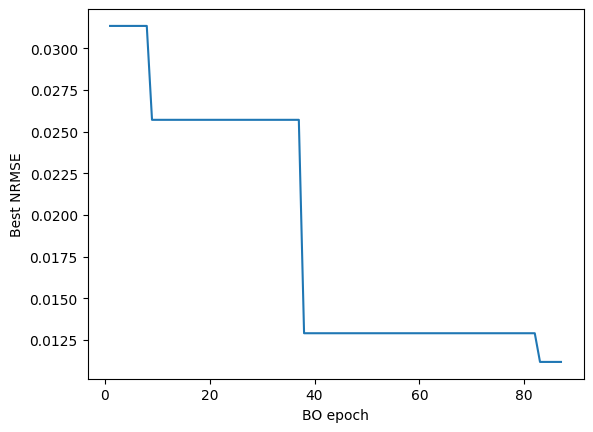

In [16]:
df_training = pd.read_csv(f"{config['simulation_run_path']}/BO/data_set_bayes_opt.csv")
df_edge_stats = pd.read_csv(f"{config['simulation_run_path']}/BO/df_edge_stats.csv")

df_plot = df_training.query('bo_iteration>0')
x = df_plot['bo_iteration']
y = df_plot['loss'].cummin()

plt.plot(x, y)
#plt.legend(title='Parameter where:')
plt.xlabel('BO epoch')
plt.ylabel('Best NRMSE')
# plt.show()
plt.savefig(f"{config['simulation_run_path']}/bo_nrmse.png")


In [17]:
if df_edge_stats.batch.drop_duplicates().shape[0] > 1:
    raise('This needs updating once we start using batches')

losses = []
for o1 in range(config["NITER"]): #num_epsilon_iter):
    curr_edge_stats = df_edge_stats[df_edge_stats.bo_iteration == o1]
    df1b = gt_edge_data.merge(curr_edge_stats, on=['edge_id'], how='left', suffixes=('_gt', '_bo'))
    curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, curr_edge_stats)
    losses.append(curr_loss)



In [18]:
# disable interactive mode
plt.ioff()

if df_edge_stats.batch.drop_duplicates().shape[0] > 1:
    raise('This needs updating once we start using batches')

Path(f"{config["simulation_run_path"]}/figs").mkdir(parents=True, exist_ok=True)

losses = []
for o1 in range(config["NITER"]): #num_epsilon_iter):
    curr_edge_stats = df_edge_stats[df_edge_stats.bo_iteration == o1]
    df1b = gt_edge_data.merge(curr_edge_stats, on=['edge_id'], how='left', suffixes=('_gt', '_bo'))
    curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, curr_edge_stats)
    losses.append(curr_loss)

    # find idx of min loss
    idx_min = np.argmin(losses)
    o1 = idx_min

    curr_edge_stats = df_edge_stats[df_edge_stats.bo_iteration == o1]
    df1b = gt_edge_data.merge(curr_edge_stats, on=['edge_id'], how='left', suffixes=('_gt', '_bo'))
    curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, curr_edge_stats)

    plt.figure()    
    # plotting diagonal line that represents a perfect data fit
    max_val = np.max([df1b.interval_nVehContrib_gt.max(), df1b.interval_nVehContrib_bo.max()])
    vec = np.arange(max_val)
    plt.plot(vec, vec, 'r-')
    plt.plot(df1b.interval_nVehContrib_gt, df1b.interval_nVehContrib_bo, 'x') 
    # plt.title(f'BO epochs: {o1}; loss: {curr_loss}')
    plt.xlabel('GT edge counts') 
    plt.ylabel('Simulated edge counts') 
    plt.savefig(f"{config["simulation_run_path"]}/figs/{o1}_bo_edge_counts.png")


    # plot of fit to GT OD vs ET OD
    plt.figure()
    # get the OD values with the best loss
    curr_od = df_training.query('bo_iteration==@o1').iloc[0][[col for col in df_training.columns if "x" in col]].values
    # bar graph side by side by x axis
    width = 0.35
    plt.bar(np.arange(len(curr_od)), curr_od, width, label='BO')
    plt.bar(np.arange(len(gt_od_vals)) + width, gt_od_vals, width, label='GT')
    plt.legend()
    plt.xlabel('OD pair')
    plt.ylabel('Demand')
    # plt.title(f'BO iteration: {o1}')
    plt.savefig(f"{config["simulation_run_path"]}/figs/{o1}_bo_od.png")


SyntaxError: f-string: unmatched '[' (246893000.py, line 7)

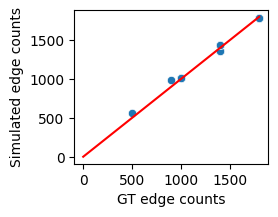

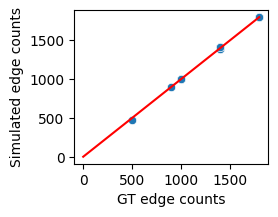

In [21]:
# draw a joint seaborn plot for initial (o1 = 0) and best (o1 = idx_min) iteration


import seaborn as sns
import matplotlib.pyplot as plt

o1 = 0
curr_edge_stats = df_edge_stats[df_edge_stats.bo_iteration == o1]
df1b = gt_edge_data.merge(curr_edge_stats, on=['edge_id'], how='left', suffixes=('_gt', '_bo'))
curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, curr_edge_stats)

idx_min = np.argmin(losses)
o2 = idx_min
curr_edge_stats = df_edge_stats[df_edge_stats.bo_iteration == o2]
df2b = gt_edge_data.merge(curr_edge_stats, on=['edge_id'], how='left', suffixes=('_gt', '_bo'))

# define another df to draw joint plot // hue = bo_iteration
df1b['bo_iteration'] = o1
df2b['bo_iteration'] = o2
df1b['type'] = 'initial'
df2b['type'] = 'best'

df_joint = pd.concat([df1b, df2b])

# plotting diagonal line that represents a perfect data fit
max_val = np.max([df1b.interval_nVehContrib_gt.max(), df1b.interval_nVehContrib_bo.max()])
vec = np.arange(max_val)

fig, ax = plt.subplots(nrows = 1 , ncols = 1, figsize=(2.5, 2))
# initial
sns.scatterplot(data=df1b, x='interval_nVehContrib_gt', y='interval_nVehContrib_bo',ax=ax)
# x label
ax.set_xlabel('GT edge counts')
# y label
ax.set_ylabel('Simulated edge counts')
ax.plot(vec, vec, 'r-')
plt.savefig(f"{config['simulation_run_path']}/{config['network_name']}_jointplot_initial.png")

fig, ax = plt.subplots(nrows = 1 , ncols = 1, figsize=(2.5, 2))
# best
sns.scatterplot(data=df2b, x='interval_nVehContrib_gt', y='interval_nVehContrib_bo',ax=ax)
# x label
ax.set_xlabel('GT edge counts')
# y label
ax.set_ylabel('Simulated edge counts')
ax.plot(vec, vec, 'r-')
plt.savefig(f"{config['simulation_run_path']}/{config['network_name']}_jointplot_best.png")
